# Sensitivity analysis

In [1]:
from SALib.sample import saltelli, fast_sampler
from SALib.sample import ff as ffs
from SALib.analyze import sobol, fast, ff
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [1]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 0.75],
               [0, 0.50],
               [0, 0.30]]
}

# Sobol

In [ ]:
sample_parameters = False
if (sample_parameters):
    param_values = saltelli.sample(problem, 2**12)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-sobol.csv")
len(t)

In [ ]:
df = pd.read_csv("../output/data/results-sobol.csv", sep = ";")
params = pd.read_csv("../output/data/param-sobol.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

In [ ]:
Si = sobol.analyze(problem, Y, print_to_console=True)

In [ ]:
total, first, second = Si.to_df()

In [ ]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')

shutil.copy("../output/plots/sobol-st.pdf", "../manuscript/plots/")
shutil.copy("../output/plots/sobol-s1.pdf", "../manuscript/plots/")
shutil.copy("../output/plots/sobol-s2.pdf", "../manuscript/plots/")

In [ ]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.4),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=10, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [ ]:
# fig.write_image("../output/plots/3D-scatter-sobol.pdf")
shutil.copy("../output/plots/3D-scatter-sobol.png", "../manuscript/plots/")

# EFast

In [ ]:

sample_parameters = False

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 2000)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-efast.csv")
t.shape

In [ ]:
df = pd.read_csv("../output/data/results-efast.csv", sep = ";")
params = pd.read_csv("../output/data/param-efast.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

In [ ]:
df.g4.describe()

In [ ]:
Sif = fast.analyze(problem, Y, print_to_console=True)

In [ ]:
Sif.plot()
plt.savefig("../output/plots/efast.pdf", bbox_inches='tight')

In [ ]:
shutil.copy("../output/plots/efast.pdf", "../manuscript/plots/")

In [ ]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.7),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [ ]:
#fig.write_image("../output/plots/3D-scatter-efast.pdf")
shutil.copy("../output/plots/3D-scatter-efast.png", "../manuscript/plots/")

# eFast with replicates

In [4]:

sample_parameters = False

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 500)
    
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-rep-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-rep-efast.csv")
t.shape

(1500, 3)

In [5]:
df = pd.read_csv("../output/data/results-rep-efast.csv", sep = ";")
params = pd.read_csv("../output/data/param-rep-efast.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df["replicate"] = pd.to_numeric(df["replicate"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]

In [8]:
replicates = df.replicate.sort_values().unique()
Y = {}
for i in replicates:
    tY = df.loc[df["replicate"] == i].g4.to_numpy()
    Y[i] = fast.analyze(problem, tY, print_to_console=False)

In [9]:
# testing
a = df.loc[df["replicate"] == 3].g4.to_numpy()
tsif = fast.analyze(problem, a, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.003605  0.289156  0.017053  0.033964
leakage        0.444692  0.781835  0.017987  0.036907
fertility      0.181110  0.456463  0.015730  0.040940


In [10]:
# create dataset
columns = Y[1]["names"]
S1 = []
ST = []

for value in Y.values():
    S1.append(value["S1"])
    ST.append(value["ST"])

S1 = pd.DataFrame(np.row_stack(S1))
S1.columns = columns
ST = pd.DataFrame(np.row_stack(ST))
ST.columns = columns

In [11]:
S1.describe()

,random-mating,leakage,fertility
count,30.000000,30.000000,30.000000
mean,0.003953,0.482336,0.198723
std,0.001941,0.034053,0.022490
min,0.001023,0.410207,0.142722
25%,0.002597,0.454800,0.188906
50%,0.003735,0.490393,0.199509
75%,0.005271,0.497370,0.212532
max,0.008254,0.546634,0.253188


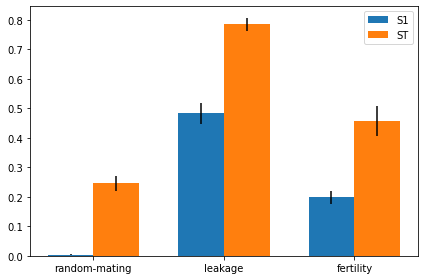

'../manuscript/plots/efast-rep.pdf'

In [32]:
# create plot
labels = columns
s1_means = S1.describe().loc["mean",].to_numpy()
st_means = ST.describe().loc["mean",].to_numpy()
s1_errors = S1.describe().loc["std",].to_numpy()
st_errors= ST.describe().loc["std",].to_numpy()


width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, s1_means, width, label='S1', yerr=s1_errors)
rects2 = ax.bar(x + width/2, st_means, width, label='ST', yerr=st_errors)

# Add some text for labels, title and custom x-axis tick labels, etc.

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(len(labels))  )
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

fig.savefig("../output/plots/efast-rep.pdf", bbox_inches='tight')
shutil.copy("../output/plots/efast-rep.pdf", "../manuscript/plots/")